# Recommender System
![alt text](https://miro.medium.com/max/687/1*-Jr1l2rlj9SBcCzlDHtN5g.jpeg)


In [ ]:
#Import all libraries needed
import numpy as np
import pandas as pd
import pandas_profiling
from sklearn.metrics.pairwise import cosine_similarity
from urllib.request import urlopen
from zipfile import ZipFile
import os
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
import time

## Content Based

In [ ]:
#Download Data
!wget https://raw.githubusercontent.com/nikitaa30/Content-based-Recommender-System/master/sample-data.csv 

--2021-11-19 02:30:32--  https://raw.githubusercontent.com/nikitaa30/Content-based-Recommender-System/master/sample-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 566516 (553K) [text/plain]
Saving to: ‘sample-data.csv’

sample-data.csv     100%[===================>] 553.24K  --.-KB/s    in 0.02s   

2021-11-19 02:30:32 (30.1 MB/s) - ‘sample-data.csv’ saved [566516/566516]



In [ ]:
#data sinopsis
ds = pd.read_csv("sample-data.csv")
ds

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."
...,...,...
495,496,Cap 2 bottoms - Cut loose from the maddening c...
496,497,Cap 2 crew - This crew takes the edge off fick...
497,498,All-time shell - No need to use that morning T...
498,499,All-wear cargo shorts - All-Wear Cargo Shorts ...


In [ ]:
#Membuat Vektor representasi dari tiap item dengan TF-IDF
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')  
tfidf_matrix = tf.fit_transform(ds['description'])

#Menghitung Similarity
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]

    results[row['id']] = similar_items[1:]
    
print('done!')

def item(id):
    return ds.loc[ds['id'] == id]['description'].tolist()[0].split(' - ')[0]

done!


In [ ]:
# Just reads the results out of the dictionary.
def recommend(item_id_sebelumnya, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id_sebelumnya) + "...")
    print("-------")
    recs = results[item_id_sebelumnya][:num]
    for rec in recs:
        print("Recommended: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")

In [ ]:
recommend(item_id_sebelumnya=2, num=5)

Recommending 5 products similar to Active sport boxer briefs...
-------
Recommended: Active sport briefs (score:0.4181663992161573)
Recommended: Cap 1 boxer briefs (score:0.1154638209862757)
Recommended: Active boxer briefs (score:0.113033922454002)
Recommended: Active briefs (score:0.112478545210916)
Recommended: Active boy shorts (score:0.11147017924424411)


## Collaborative - Memory Based

In [ ]:
#Download data berformat zip, lalu diunzip
!wget 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
!unzip 'ml-latest-small.zip'

--2021-11-19 02:30:33--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  1.46MB/s    in 0.6s    

2021-11-19 02:30:34 (1.46 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
rating_data = pd.read_csv('ml-latest-small/ratings.csv')
movie_data = pd.read_csv('ml-latest-small/movies.csv')
rating_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
rating_data.drop('timestamp', axis = 1, inplace=True)
rating_data.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


In [ ]:
movie_data.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


Kedua file ini saat ini sudah memiliki data peringkat pengguna dan data film yang terpisah.

Namun, karena kedua file ini memiliki kesamaan movieId, keduanya dapat digabungkan berdasarkan movieId.
Mari buat pivot_table untuk data rating berdasarkan film-pengguna.

In [ ]:
user_movie_rating = pd.merge(rating_data, movie_data, on = 'movieId')
user_movie_rating.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
movie_user_rating = user_movie_rating.pivot_table('rating', index = 'title', columns='userId')
user_movie_rating = user_movie_rating.pivot_table('rating', index = 'userId', columns='title')
movie_user_rating.head(2)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
user_movie_rating

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Seperti sebelumnya, karena item-based filtering oleh karena itu kita harus mengubah satu kolom menjadi kolom Film, kolom lainnya adalah Pengguna.

Dalam keadaan ini, pertama-tama kita akan melanjutkan dengan pemfilteran kolaboratif berbasis item.

Pertama, nilai NaN diubah menjadi 0.

In [ ]:
movie_user_rating.fillna(0, inplace = True)
movie_user_rating.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Saat ini, baris adalah film dan col adalah pengguna.

Dalam item-based collaborative filtering, apabila pelanggan yang membeli suatu produk juga membeli produk lainnya, misalnya: saat kita ke supermarket kita membeli pasta gigi, juga beli sabun mandi.
Dengan kata lain, pelanggan yang melihat suatu film juga melihat film lain yg serupa. basis ini didasarkan pada peringkat yang sama.
Sekarang, mari kita periksa apakah peringkatnya serupa dengan mengukur kesamaan kosinus.

In [ ]:
item_based_collabor = cosine_similarity(movie_user_rating)
item_based_collabor

array([[1.        , 0.        , 0.        , ..., 0.32732684, 0.        ,
        0.        ],
       [0.        , 1.        , 0.70710678, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.70710678, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.32732684, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [ ]:
item_based_collabor = pd.DataFrame(data = item_based_collabor, index = movie_user_rating.index, columns = movie_user_rating.index)
item_based_collabor

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.141653,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.285169,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.800000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.655610,0.0,0.000000,0.000000,0.212814,0.919145,0.000000,0.000000,0.120996,0.000000,0.0,0.0,0.149201,0.000000,0.0,0.000000,0.178042,0.000000,0.000000,0.342055,0.543305,0.707107,0.0,0.000000,0.139431,0.327327,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.715542,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150269,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.124109,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.148970,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.000000,0.000000,0.000000,0.707107,0.505964,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106256,0.0,0.0,0.000000,0.0,0.0,0.707107,0.000000,0.000000,0.0,0.197457,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.105338,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.00

Dengan cara ini, kesamaan antar item telah berhasil didapatkan.

Sekarang, kita dapat menambahkan fungsi yang merekomendasikan item yg serupa.

In [ ]:
def get_item_based_collabor(title, r=6):
    print('Terima kasih sudah menonton', title, 'kami rekomendasikan anda menonton film ini:', )
    rf = item_based_collabor[title].sort_values(ascending=False)[:r+1]
    if title in rf:
      del rf[title]
    return rf

In [ ]:
start = time.time()
rekomendasinya = get_item_based_collabor("'Til There Was You (1997)", 10)
end = time.time()
waktu = end - start
print(rekomendasinya)
print(waktu)

Terima kasih sudah menonton 'Til There Was You (1997) kami rekomendasikan anda menonton film ini:
title
All This, and Heaven Too (1940)                      0.857493
'Salem's Lot (2004)                                  0.857493
Absence of Malice (1981)                             0.651057
Affair to Remember, An (1957)                        0.592057
10 (1979)                                            0.552657
Best Seller (1987)                                   0.514496
Man and a Woman, A (Un homme et une femme) (1966)    0.514496
84 Charing Cross Road (1987)                         0.493049
3 Women (Three Women) (1977)                         0.474512
All That Heaven Allows (1955)                        0.450090
Name: 'Til There Was You (1997), dtype: float64
0.00571894645690918


## Collaborative - Model Based
Disini kita akan menggunakan SVD untuk membuat rekomendasi

In [ ]:
user_movie_rating.fillna(0, inplace = True)
user_movie_rating

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
#Preprocessing
R = user_movie_rating.values                  #Menyimpan angka pada Matriks
U, sigma, Vt = svds(R, k = 50)                #membuat singular value decomposition untuk menyederhanakan matriks
sigma = np.diag(sigma)                        #eigen value
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = user_movie_rating.columns)
preds_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
0,-0.069287,0.018767,-0.042895,-0.038633,-0.049699,-0.007370,0.540617,-0.009627,-0.605885,0.211192,-0.033895,0.195078,-0.210390,0.012905,-0.106125,0.015009,0.016953,-0.229179,0.452847,0.030565,-0.006542,0.015132,0.021832,0.853709,2.282806,0.038492,0.011355,0.101706,-0.006805,0.154562,-0.067790,-0.042685,-0.193310,-0.006049,0.703581,0.131620,-0.014071,-0.015635,0.100297,0.053498,...,-0.100010,-0.012508,-0.015278,-0.075320,0.062763,0.087449,0.097166,-0.006492,-0.012836,0.096962,0.156447,-0.236678,0.024855,-0.029849,0.007843,0.017466,-0.319027,-0.047527,-0.023573,0.004351,0.178672,0.015686,0.094351,-0.180425,0.417934,0.120114,0.029285,0.021832,-0.378319,-0.120229,0.013099,-0.460020,0.019474,-0.054220,-0.021501,0.339775,-0.286041,-0.187782,1.500375,0.033463
1,-0.028678,-0.012015,-0.010785,0.000667,-0.003074,-0.007729,0.003357,0.008565,0.149107,-0.006173,-0.000156,-0.012226,0.055894,-0.000026,0.014779,0.002962,0.207164,0.010825,-0.086349,0.009692,-0.005517,-0.015557,0.006923,0.037942,-0.200615,-0.015568,-0.002724,-0.042790,-0.000018,-0.037023,-0.000311,0.005371,-0.040217,-0.000016,0.067822,0.008982,-0.009415,-0.010461,-0.051584,0.211385,...,-0.012475,-0.008369,0.005048,-0.023814,0.017000,-0.003172,-0.003524,-0.002360,0.011420,0.022353,0.210498,-0.008335,-0.022022,-0.006049,0.005447,0.005539,0.363422,-0.020940,0.009278,-0.000115,0.569966,0.010894,0.027846,0.060573,0.471583,-0.021765,-0.016003,0.006923,0.160000,-0.007867,0.004154,-0.015531,-0.027589,-0.034685,0.016193,0.059240,-0.104825,-0.010205,0.056609,-0.000368
2,0.017487,0.001239,0.004907,0.002812,0.002341,-0.001500,0.089847,-0.006716,0.027147,-0.007325,0.002185,0.000654,0.005270,-0.001101,-0.012595,0.000122,-0.026216,0.006248,-0.010800,0.001088,-0.000880,0.007167,0.000777,-0.004390,0.060129,-0.000519,0.001303,0.014757,0.000658,0.001284,0.004369,-0.010331,0.014487,0.000584,-0.019523,-0.008015,0.001951,0.002168,-0.008141,0.011103,...,0.006882,0.001734,-0.001115,0.017889,-0.002791,0.

In [ ]:
def recommend_movies(userID, num_recommendations=5):
  user_row_number = userID - 1 
  sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) #sorting nilai dr matriks dekomposisi
  user_data = rating_data[rating_data.userId == (userID)]
  user_full = (user_data.merge(movie_data, how = 'left', left_on = 'movieId', 
                right_on = 'movieId').sort_values(['rating'], ascending=False)) #menggabungkan dataframe rating dan list movie yang ratingnya sudah disorting
  
  recommendations = (movie_data[~movie_data['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'title',
               right_on = 'title').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                                                                      #memfilter film yang sudah ditonton    

  return user_full, recommendations

sudah_ditonton, rekomendasi = recommend_movies(300, 10)
sudah_ditonton.head()

,userId,movieId,rating,title,genres
16,300,6016,5.0,City of God (Cidade de Deus) (2002),Action|Adventure|Crime|Drama|Thriller
11,300,2858,5.0,American Beauty (1999),Drama|Romance
29,300,112290,5.0,Boyhood (2014),Drama
27,300,109487,5.0,Interstellar (2014),Sci-Fi|IMAX
24,300,81591,5.0,Black Swan (2010),Drama|Thriller


In [ ]:
rekomendasi

,movieId,title,genres
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3128,4226,Memento (2000),Mystery|Thriller
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
43,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
2359,3147,"Green Mile, The (1999)",Crime|Drama
891,1193,One Flew Over the Cuckoo's Nest (1975),Drama
97,110,Braveheart (1995),Action|Drama|War
4782,7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
6987,68157,Inglourious Basterds (2009),Action|Drama|War
3625,4995,"Beautiful Mind, A (2001)",Drama|Romance


In [ ]:
start = time.time()
sudah_ditonton, rekomendasi = recommend_movies(30, 10)
end = time.time()
waktu = end - start
print(rekomendasi)
print(waktu)

      movieId  ...                                     genres
2214     2959  ...                Action|Crime|Drama|Thriller
7671    89745  ...               Action|Adventure|Sci-Fi|IMAX
2662     3578  ...                     Action|Adventure|Drama
1492     2028  ...                           Action|Drama|War
506       593  ...                      Crime|Horror|Thriller
311       356  ...                   Comedy|Drama|Romance|War
959      1270  ...                    Adventure|Comedy|Sci-Fi
893      1197  ...    Action|Adventure|Comedy|Fantasy|Romance
7281    76093  ...  Adventure|Animation|Children|Fantasy|IMAX
255       296  ...                Comedy|Crime|Drama|Thriller

[10 rows x 3 columns]
0.02010798454284668


In [ ]:
rekomendasi

,movieId,title,genres
2214,2959,Fight Club (1999),Action|Crime|Drama|Thriller
7671,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
2662,3578,Gladiator (2000),Action|Adventure|Drama
1492,2028,Saving Private Ryan (1998),Action|Drama|War
506,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller


# Latihan

In [ ]:
#Gunakan file ratings_small.csv
data = pd. .....
data = data.pivot_table('rating', index = 'userId', columns = 'movieId')
data

In [ ]:
#Gunakan file ratings_small.csv dan tmdb_5000_movies.csv
ratings = pd. ...
movies = pd. ...

In [ ]:
movies.rename(columns = {'id': 'movieId'}, inplace = True) #mengganti kolom "id" dengan "movieId" agar mudah dimerge dengan ratings

In [ ]:
#Merge movies dan ratings berdasarkan "movieId", ketik dibawah sini
ratings_movies = ...
ratings_movies.head()

In [ ]:
data = ratings_movies.pivot_table('rating', index = 'userId', columns = 'title').fillna(0)
data

Lakukan proses membuat rekomendasi item-based

Coba dites untuk 10 film rekomendasi setelah menonton "Harry Potter and the Half-Blood Prince". Jika sudah benar kurang lebih hasilnya begini :

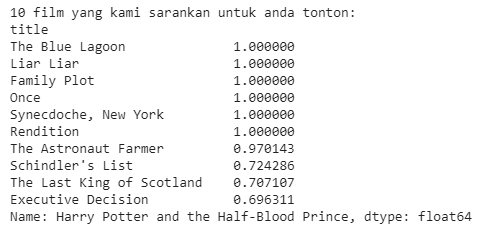